Libraries

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
path ='/content/drive/MyDrive/ DS/ NLP Projects/ Sentiment Analysis/' 
stopwords_list = path+'bangla_stopwords.txt'
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
data = pd.read_csv('/content/drive/MyDrive/ DS/Product Review RawData.csv',encoding='UTF-8')
data


,Reviews,Sentiments,Classification
0,ডেলিভারিতে আমি আনেক খুশি প্যাকেজিং ভালো ছিলো,Positive,0
1,অরিজিনাল টা দেওয়ার জন্য ধন্যবাদ,Positive,0
2,চা অরজিনাল ছিল কোন পিনিক না থাকলেও খেতে দারুন,Positive,0
3,অস্থির পিনিক,Positive,0
4,অরিজিনাল টেস্ট,Positive,0
...,...,...,...
916,এদের জন্যই দেশের নাম খারাপ হয়,Negative,1
917,তোদের লজ্জা করা উচিত,Negative,1
918,কমপ্লেইন করার পরও লাভ হয় নি,Negative,1
919,বাজে ব্যবহার,Negative,1


Dataset Preparation

In [235]:
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Classification ==0]),
      "\nTotal Negative Reviews:",len(data[data.Classification==1])
     )
      

Total Reviews: 921 
Total Positive Reviews: 481 
Total Negative Reviews: 440


In [236]:
data.columns

Index(['Reviews', 'Sentiments', 'Classification'], dtype='object')

In [237]:

# print some unprocessed reviews
sample_data = [10,100,150,200,250,600,650,666,689,640,650,700,750,800]
for i in sample_data:
      print(data.Reviews[i],'\n','Sentiment:-- ',data.Sentiments[i],'\n')

অসাধারন যেমন চেয়েছি তেমনই পেয়েছি এবং দামও কম 
 Sentiment:--  Positive 

দ্রুত ডেলিভারি দেয়ার জন্য দারাজকে ধন্যবাদ 
 Sentiment:--  Positive 

এটা ভালো  
 Sentiment:--  Positive 

আসল পণ্য ভাল নেটওয়ার্ক কভারেজ এবং দ্রুত বিতরণ 
 Sentiment:--  Positive 

অনেক ভালো প্রডাক্ট দেবার জন্য ধন্যবাদ 
 Sentiment:--  Positive 

সময় মত ডেলিভারি পেয়েছি কিন্তু প্রডাক্ট খুব ভালো কাজ করছে না
 
 Sentiment:--  Negative  

সুপারিশ করবে না 
 Sentiment:--  Negative  

সাউন্ড কোয়ালিটি আরো খারাপ 
 Sentiment:--  Negative  

খুব আলগা 
 Sentiment:--  Negative  

খুব ধীর ডেলিভারি 
 Sentiment:--  Negative  

সুপারিশ করবে না 
 Sentiment:--  Negative  

লাইট ২১ টা নষ্ট হলে হোক বাট এইসব লিকেজ চেক করে দিবেন ভাই  ২ বার শক খেয়েছি  ডান হাত এখনও কাপছে  
 Sentiment:--  Negative  

আমি চাইলাম কালো দিলেন সাদা এইডা কিছু হইলো? এমন করে ব্যবসা করা যায় না 
 Sentiment:--  Negative  

কাজ করে না 
 Sentiment:--  Negative  



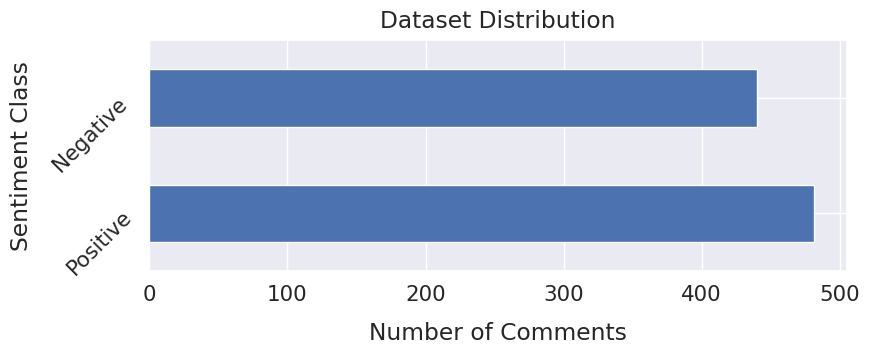

In [238]:
sns.set(font_scale=1.4)
data['Sentiments'].value_counts().plot(kind='barh', figsize=(9, 3))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

Data Cleaning

In [239]:
!pip install bnltk
!pip install stopwordsiso
!pip install bangla-stemmer
!pip install bnlp_toolkit
import nltk
from bnlp import BasicTokenizer
from stopwordsiso import stopwords
from bangla_stemmer.stemmer import stemmer
import string
nltk.download('punkt')
nltk.download('perluniprops')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


True

In [240]:
def tokenize_text(text):
    btokenizer = BasicTokenizer()
    tokens = btokenizer.tokenize(text)
    return tokens

def remove_stopwords(tokens):
    stop_words = set(stopwords(['bn']))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

def remove_punctuation(tokens):
    translator = str.maketrans('', '', string.punctuation)
    tokens_without_punct = [token.translate(translator) for token in tokens]
    return tokens_without_punct

def stem_tokens(tokens):
    stemmer_obj = stemmer.BanglaStemmer()
    stemmed_tokens = [stemmer_obj.stem(token) for token in tokens]
    return stemmed_tokens

def preprocess_text(text):
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuation(tokens)
    tokens = stem_tokens(tokens)
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text


In [241]:
# Apply the function into the dataframe
data['cleaned'] = data['Reviews'].apply(preprocess_text)  



applied first rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied fourth rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied first rules..
applied first rules..
applied second rules..
applied first rules..
applied fourth rules..
applied first rules..
applied fourth rules..
applied fourth rules..
applied second rules..
applied fourth rules..
applied first rules..
applied second rules..
applied fourth rules..
applied first rules..
applied 

In [242]:
# print some cleaned reviews from the dataset
sample_data = [10,100,150,200,250,600,650,666,689,640,650,700,750,800]
for i in sample_data:
     print('Original:\n',data.Reviews[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Sentiments[i],'\n')

Original:
 অসাধারন যেমন চেয়েছি তেমনই পেয়েছি এবং দামও কম 
Cleaned:
 অসাধারন চেয়েছি তেমন পেয়েছি দাম কম 
 Sentiment:--  Positive 

Original:
 দ্রুত ডেলিভারি দেয়ার জন্য দারাজকে ধন্যবাদ 
Cleaned:
 দ্রুত ডেলিভারি দেয় দারাজ ধন্যবাদ 
 Sentiment:--  Positive 

Original:
 এটা ভালো  
Cleaned:
 ভালো 
 Sentiment:--  Positive 

Original:
 আসল পণ্য ভাল নেটওয়ার্ক কভারেজ এবং দ্রুত বিতরণ 
Cleaned:
 আসল পণ্য ভাল নেটওয়ার্ক কভারেজ দ্রুত বিতরণ 
 Sentiment:--  Positive 

Original:
 অনেক ভালো প্রডাক্ট দেবার জন্য ধন্যবাদ 
Cleaned:
 ভালো প্রডাক্ট দেব ধন্যবাদ 
 Sentiment:--  Positive 

Original:
 সময় মত ডেলিভারি পেয়েছি কিন্তু প্রডাক্ট খুব ভালো কাজ করছে না
 
Cleaned:
 সময় মত ডেলিভারি পেয়েছি প্রডাক্ট ভালো 
 Sentiment:--  Negative  

Original:
 সুপারিশ করবে না 
Cleaned:
 সুপারিশ 
 Sentiment:--  Negative  

Original:
 সাউন্ড কোয়ালিটি আরো খারাপ 
Cleaned:
 সাউন্ড কোয়ালিটি আরো খারাপ 
 Sentiment:--  Negative  

Original:
 খুব আলগা 
Cleaned:
 আলগা 
 Sentiment:--  Negative  

Original:
 খুব ধীর ডেলিভারি 
Cleaned:
 ধীর

Remove Low lenght data

Dataset Summary

In [243]:
def data_summary(data):
    
    """
    This function will print the summary of the reviews and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(data.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in data.Classification.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(data[data.Classification==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(data[data.Classification==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(data[data.Classification==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(data)


Class Name :  0
Number of Documents:481
Number of Words:2402
Number of Unique Words:904
Most Frequent Words:

ভালো	138
ভাল	103
প্রোডাক্ট	75
পণ্য	51
দাম	42
ধন্যবাদ	40
পেয়েছি	33
এক	29
ডেলিভারি	27
মান	25

Class Name :  1
Number of Documents:440
Number of Words:2080
Number of Unique Words:986
Most Frequent Words:

প্রোডাক্ট	42
বাজে	41
এক	36
ভালো	31
খারাপ	25
অর্ড	24
পণ্য	22
টাকা	20
টা	19
নষ্ট	18
Total Number of Unique Words:1600


Dataset Summary Visualization

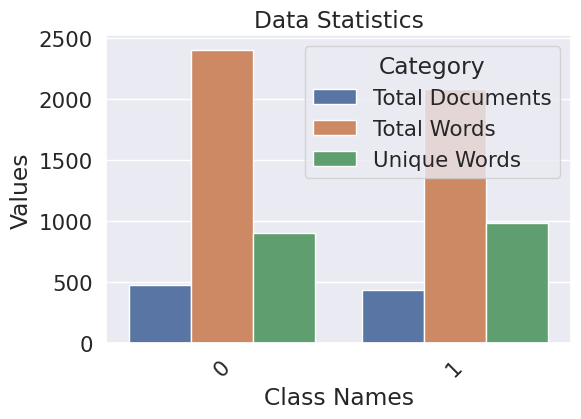

In [244]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(6, 4))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

Comment Lenght Distribution

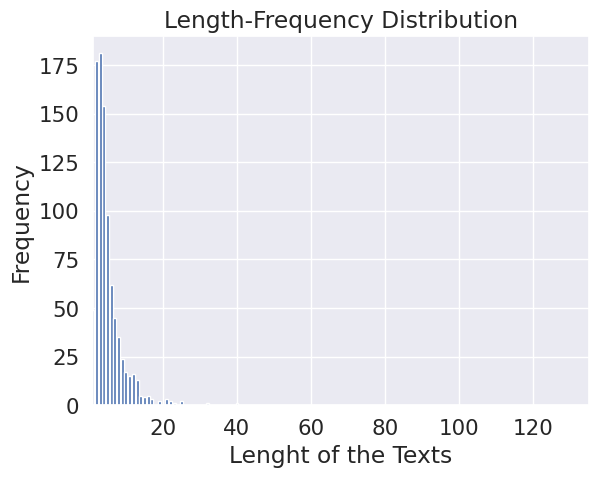

Maximum Length of a review: 40
Minimum Length of a review: 0
Average Length of a reviews: 5.0


In [245]:
# Calculate the Review of each of the Review
data['ReviewLength'] = data.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in data.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a review: {max(data.ReviewLength)}")
print(f"Minimum Length of a review: {min(data.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(data.ReviewLength),0)}")

Take only Positive and Negative Class for Model Building

**Lable Encoding and Dataset Splitting**

In [246]:
#==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector . 
    
    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array) 
        
    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.8,
                                                  test_size = 0.2,random_state =0)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

In [247]:
data.cleaned = data.cleaned.apply(lambda x:x.replace('\n',' '))

Model Building Using Machine Learning
Feature Extraction Using TF-IDF 

In [248]:
#======================================
                                            ##### Unigram Tf-idf value calculation
                                            #======================================
            
def calc_gram_tfidf(reviews,gram):
    """
    This function will return the tf-idf value of the respective gram features . 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(reviews)
    
    return tfidf,X

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve

In [250]:
#============================================
                                              #########  Classifiers Defination  #########
                                              #============================================
def ml_models_defination(): 
    """
    This function consists the models defination for All gram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    
    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.15)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM']
    #model_names = ['Logistic Regression']
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model]
    #ml_models = [lr_model]
    return ml_models,model_names 


                                          #============================================
                                           ####### Model Evaluation Function ############
                                           #=============================================

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.
    
    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        
    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100 
    
    return my_dict  

                                        #========================================
                                        #### Model Performane into Dataframe #####
                                        #=========================================
            
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.
    
    Args:
        performance_dict: a dictionary of all the parameters for each models
        
    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','MNB','KNN','Linear SVM','RBF SVM']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df


Model Training

In [251]:
## save the performance of the model for each gram feature 
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(data.cleaned,gram)
    labels = label_encoding(data.Sentiments,False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels) 
    ml_models,model_names = ml_models_defination()
    # call model accuracy function and save the metrices into a dictionary
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}
    #Save the performance parameter into json file
    with open(path+f'ml_performance_{gram_names[i]}.json', 'w') as f:
           json.dump(accuracy, f)

Feature Size :======> 1600

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 921 
	Training		 736 
	Test			 185


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 4689

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 921 
	Training		 736 
	Test			 185


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Feature Size :======> 7346

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 921 
	Training		 736 
	Test			 185


Performance Table

In [252]:

# Load all the json files
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  print(f"\n========== Performace Table for {gram} feature:========\n",table)
  print(f"\n========In case of {gram} feature:========\n")
  print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis = 0)]} at = {max(table.Accuracy)}")
  print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis = 0)]} at = {max(table['F1 Score'] )}")
  print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'] )}")
  print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis = 0)]} at = {max(table['Recall'] )}")


========== Performace Table for Unigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     84.32      87.06   80.43     83.62          LR
1     69.19      63.78   88.04     73.97          DT
2     75.68      70.43   88.04     78.26          RF
3     79.46      79.35   79.35     79.35         MNB
4     50.81      50.28   97.83     66.42         KNN
5     83.78      88.75   77.17     82.56  Linear SVM
6     83.24      89.61   75.00     81.66     RBF SVM

========In case of Unigram feature:========

Highest Accuracy achieved by LR at = 84.32
Highest F1-Score achieved by LR at = 83.62
Highest Precision Score achieved by RBF SVM at = 89.61
Highest Recall Score achieved by KNN at = 97.83

========== Performace Table for Bigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     83.78      85.23   81.52     83.33          LR
1     67.03      62.40   84.78     71.89          DT
2     76.22      69.67   92.39     79.44          RF
3     81.08 

Performance Visualization

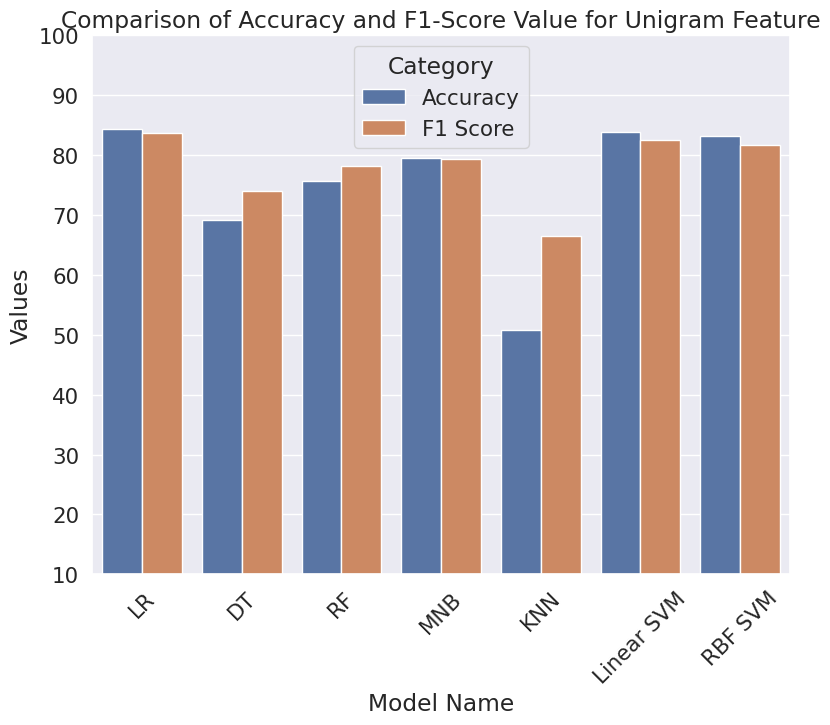

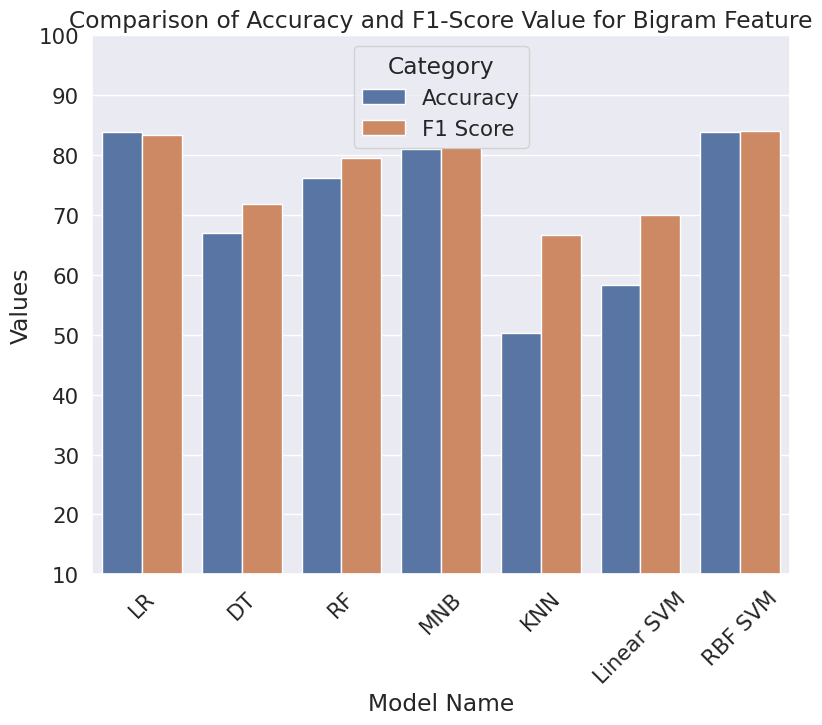

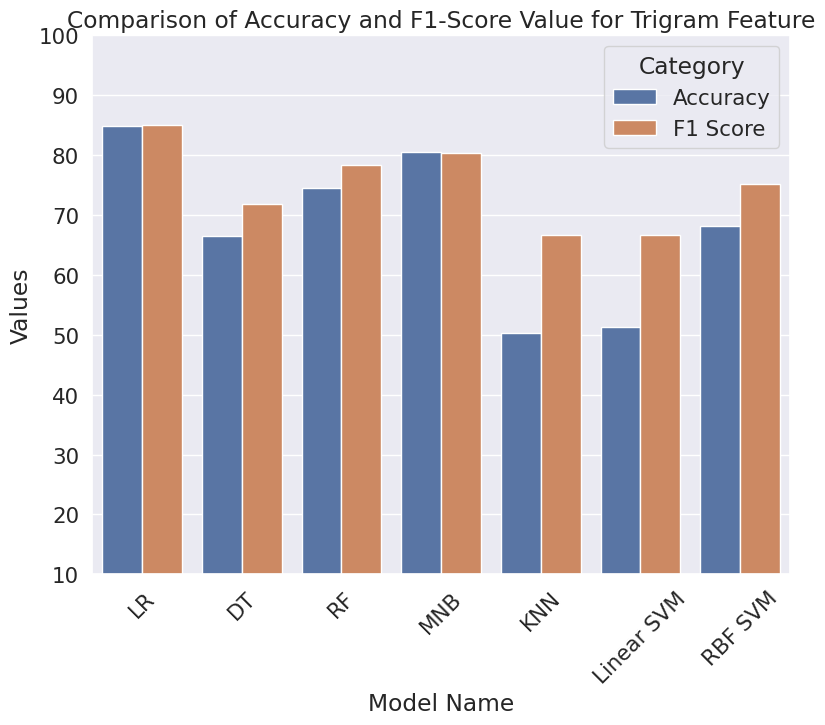

In [253]:
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  df = pd.melt(table[['Accuracy','F1 Score','Model Name']], id_vars="Model Name", var_name="Category", value_name="Values")
  plt.figure(figsize=(9,7))
  ax = plt.subplot()
  sns.barplot(data=df,x='Model Name', y='Values' ,hue='Category')
  ax.set_xlabel('Model Name') 
  ax.set_title(f'Comparison of Accuracy and F1-Score Value for {gram} Feature')
  ax.set_ylim([10,100])
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);